In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn spacy tensorflow wordcloud imblearn
!python -m spacy download en_core_web_md


     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     ---------------------------------------- 0.4/42.8 MB 13.2 MB/s eta 0:00:04
      --------------------------------------- 1.0/42.8 MB 12.2 MB/s eta 0:00:04
     -- ------------------------------------- 2.4/42.8 MB 12.0 MB/s eta 0:00:04
     -- ------------------------------------- 2.6/42.8 MB 12.0 MB/s eta 0:00:04
     --- ------------------------------------ 3.6/42.8 MB 11.0 MB/s eta 0:00:04
     ---- ----------------------------------- 4.4/42.8 MB 11.8 MB/s eta 0:00:04
     ---- ----------------------------------- 5.0/42.8 MB 11.9 MB/s eta 0:00:04
     ----- ---------------------------------- 5.9/42.8 MB 12.5 MB/s eta 0:00:03
     ------ --------------------------------- 6.8/42.8 MB 12.5 MB/s eta 0:00:03
     ------- -------------------------------- 7.9/42.8 MB 12.4 MB/s eta 0:00:03
     -------- ------------------------------- 8.9/42.8 MB 12.4 MB/s eta 0:00:03
     -------- ------------------------------- 9.

In [3]:
!pip install keras-tuner


# EDA
Here we load and explore the contents of the data

In [4]:
import pandas as pd

# Load the data
data = pd.read_excel('Reviews.xlsx')

# Display the first few rows of the dataset
data.head()


,Restaurant Name,Restaurant Type,Star Rating,Sentiment,Reviews
0,Village Burger,Hamburger restaurant,4,Positive,Pretty good burger. The Chicago dog is awesome.
1,Village Burger,Hamburger restaurant,4,Positive,NaN
2,Village Burger,Hamburger restaurant,4,Positive,I usually go during the day when the children ...
3,Village Burger,Hamburger restaurant,5,Positive,Village Burger's food quality is still the sam...
4,Village Burger,Hamburger restaurant,5,Positive,NaN


Number of rows: 5000, Number of columns: 5
Missing values in each column:
 Restaurant Name       0
Restaurant Type       0
Star Rating           0
Sentiment             0
Reviews            1911
dtype: int64
Number of duplicate entries: 1891


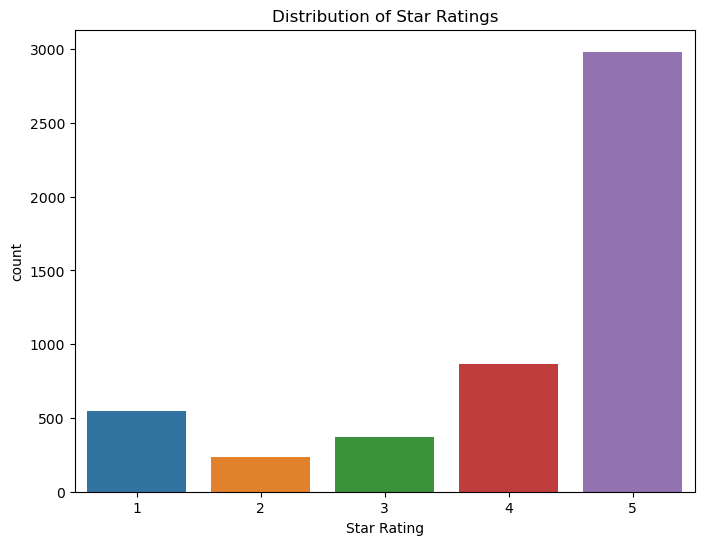

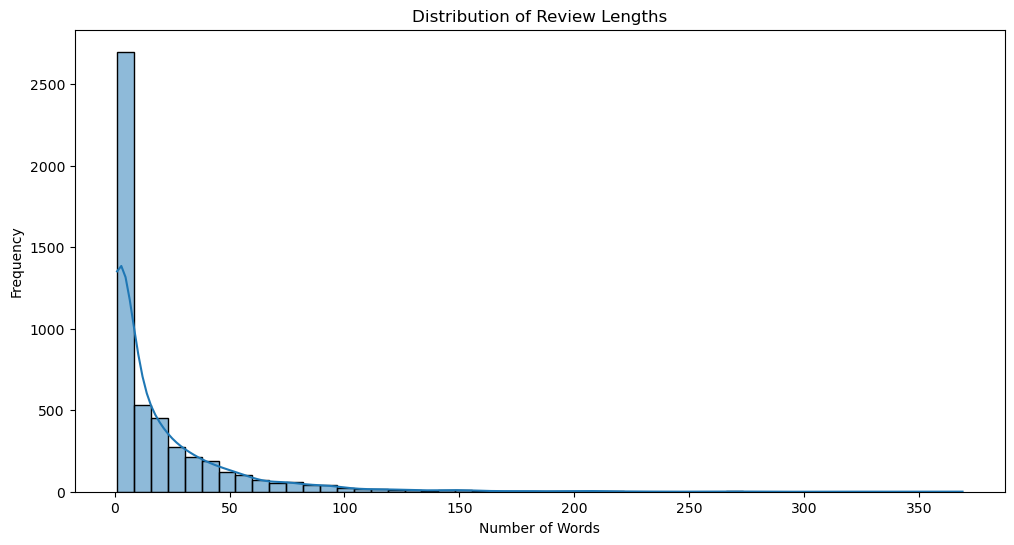

Summary statistics for review lengths:
 count    5000.000000
mean       19.358800
std        31.439233
min         1.000000
25%         1.000000
50%         6.000000
75%        25.000000
max       369.000000
Name: Review Length, dtype: float64


In [5]:
# Checking the number of rows and columns
print(f"Number of rows: {data.shape[0]}, Number of columns: {data.shape[1]}")

# Checking for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Checking for duplicate entries
duplicate_entries = data.duplicated().sum()
print("Number of duplicate entries:", duplicate_entries)

# Summary statistics
data.describe()

# Visualizing the distribution of star ratings
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='Star Rating', data=data)
plt.title('Distribution of Star Ratings')
plt.show()

# Adding a new column for review length
data['Review Length'] = data['Reviews'].apply(lambda x: len(str(x).split()))

# Display the distribution of review lengths
plt.figure(figsize=(12, 6))
sns.histplot(data['Review Length'], bins=50, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Summary statistics for review lengths
print("Summary statistics for review lengths:\n", data['Review Length'].describe())


# DATA CLEANING AND PREPROCESSING
Here we denoise the data by removing missing values and duplicates. Then we standardize the text and transform it into a suitable format for model training.

In [6]:
# Dropping rows with missing values
data.dropna(inplace=True)

# Dropping duplicate rows based on the 'Reviews' column
data.drop_duplicates(subset='Reviews', inplace=True)

# Ensuring consistent formatting for 'Restaurant Name'
data['Restaurant Name'] = data['Restaurant Name'].str.strip()

# Lowercasing the review text for consistency
data['Reviews'] = data['Reviews'].str.lower()

# Removing special characters from the reviews
import re
data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Display the cleaned data
data.head()


,Restaurant Name,Restaurant Type,Star Rating,Sentiment,Reviews,Review Length
0,Village Burger,Hamburger restaurant,4,Positive,pretty good burger the chicago dog is awesome,8
2,Village Burger,Hamburger restaurant,4,Positive,i usually go during the day when the children ...,92
3,Village Burger,Hamburger restaurant,5,Positive,village burgers food quality is still the same...,38
5,Village Burger,Hamburger restaurant,5,Positive,its always good food and service whenever we go,9
7,Village Burger,Hamburger restaurant,5,Positive,great burgers and food in general,7


# WORD EMBEDDINGS
We represent the text with numbers, so that the modls can understand it.

In [7]:
import spacy

# Load the spaCy model for English
nlp = spacy.load('en_core_web_md')

# Function for text preprocessing
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

# Applying preprocessing to the 'Reviews' column
data['Processed Reviews'] = data['Reviews'].apply(preprocess_text)

# Display the processed data
data.head()


,Restaurant Name,Restaurant Type,Star Rating,Sentiment,Reviews,Review Length,Processed Reviews
0,Village Burger,Hamburger restaurant,4,Positive,pretty good burger the chicago dog is awesome,8,pretty good burger chicago dog awesome
2,Village Burger,Hamburger restaurant,4,Positive,i usually go during the day when the children ...,92,usually day child school ppl work turkey burge...
3,Village Burger,Hamburger restaurant,5,Positive,village burgers food quality is still the same...,38,village burger food quality ve upgrade buildin...
5,Village Burger,Hamburger restaurant,5,Positive,its always good food and service whenever we go,9,good food service
7,Village Burger,Hamburger restaurant,5,Positive,great burgers and food in general,7,great burger food general


In [9]:
import numpy as np

# Function to get the average embedding for a review
def get_average_embedding(text):
    doc = nlp(text)
    if len(doc) > 0:
        embeddings = [token.vector for token in doc]
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(300)

# Applying the embedding function to the processed reviews
data['Embedding'] = data['Processed Reviews'].apply(get_average_embedding)

# Checking the first few embeddings
data['Embedding'].head()


0    [-0.29996496, 0.3040258, -3.6478665, -2.521796...
2    [0.77957106, 0.96065533, -3.189286, -0.0812229...
3    [-0.24066663, 0.65160114, -3.9873984, -0.22587...
5    [0.4246067, -2.4949932, -4.5720234, 0.088335, ...
7    [-0.043997526, -2.6143398, -4.8268576, 0.04936...
Name: Embedding, dtype: object

In [10]:


from sklearn.model_selection import train_test_split

# Extracting features (X) and labels (y)
X = np.vstack(data['Embedding'].values)
y = data['Sentiment'].values

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# MODEL TRAINING- MACHINE LEARNING
We train and test our three Machine learning models with the data.

In [11]:
# RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Training the Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predicting and evaluating
y_pred_rf = rf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.8281505728314239
              precision    recall  f1-score   support

    Negative       0.83      0.59      0.69       141
     Neutral       0.25      0.03      0.05        37
    Positive       0.83      0.97      0.90       433

    accuracy                           0.83       611
   macro avg       0.64      0.53      0.55       611
weighted avg       0.80      0.83      0.80       611



In [12]:
# SUPPORT VECTOR CLASSIFIER

from sklearn.svm import SVC

# Training the SVC model
svc = SVC(kernel='rbf', C=10, gamma='auto')
svc.fit(X_train, y_train)

# Predicting and evaluating
y_pred_svc = svc.predict(X_test)
print(f"SVC Accuracy: {accuracy_score(y_test, y_pred_svc)}")
print(classification_report(y_test, y_pred_svc))


SVC Accuracy: 0.8543371522094927
              precision    recall  f1-score   support

    Negative       0.82      0.79      0.81       141
     Neutral       0.07      0.03      0.04        37
    Positive       0.89      0.94      0.92       433

    accuracy                           0.85       611
   macro avg       0.59      0.59      0.59       611
weighted avg       0.82      0.85      0.84       611



In [13]:
# NAIVE BAYES

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the reviews into TF-IDF features
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(data['Processed Reviews'])

# Split the TF-IDF data into training and testing sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Training the Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# Predicting and evaluating
y_pred_nb = nb.predict(X_test_tfidf)
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb)}")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.7900826446280992
              precision    recall  f1-score   support

    Negative       0.93      0.33      0.48       126
     Neutral       0.00      0.00      0.00        40
    Positive       0.78      1.00      0.87       439

    accuracy                           0.79       605
   macro avg       0.57      0.44      0.45       605
weighted avg       0.76      0.79      0.74       605



# MODEL TRAINING - DEEP LEARNING MODELS
We train and test the two Deep Learning models

In [9]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Convert string labels to integer labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the integer labels
y_train_one_hot = to_categorical(y_train_encoded, num_classes=3)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=3)


In [10]:
# Building the CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

cnn = Sequential([
    Embedding(input_dim=X_train.shape[1], output_dim=128),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(3, activation='softmax')  # 3 output neurons for 3 classes
])

# Compiling the model
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
cnn.fit(X_train, y_train_one_hot, epochs=5, batch_size=64, validation_data=(X_test, y_test_one_hot))


Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.6593 - loss: 0.9159 - val_accuracy: 0.7087 - val_loss: 0.7461
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.7219 - loss: 0.7471 - val_accuracy: 0.7087 - val_loss: 0.7335
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.7212 - loss: 0.7356 - val_accuracy: 0.7087 - val_loss: 0.7169
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.7184 - loss: 0.7076 - val_accuracy: 0.7103 - val_loss: 0.6890
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.7302 - loss: 0.6825 - val_accuracy: 0.7610 - val_loss: 0.6419


In [11]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Convert string labels to integer labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the integer labels
y_train_one_hot = to_categorical(y_train_encoded, num_classes=3)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=3)



In [12]:
# Building the RNN model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense


rnn = Sequential([
    Embedding(input_dim=X_train.shape[1], output_dim=128),
    SimpleRNN(128, activation='relu'),
    Dense(3, activation='softmax')  # 3 output neurons for 3 classes
])

# Compiling the model
rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
rnn.fit(X_train, y_train_one_hot, epochs=5, batch_size=64, validation_data=(X_test, y_test_one_hot))


Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6749 - loss: 0.9134 - val_accuracy: 0.7087 - val_loss: 0.7277
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7134 - loss: 0.7358 - val_accuracy: 0.7087 - val_loss: 0.7067
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.7236 - loss: 0.7107 - val_accuracy: 0.7087 - val_loss: 0.6991
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.7178 - loss: 0.6894 - val_accuracy: 0.7087 - val_loss: 0.6979
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.7190 - loss: 0.6841 - val_accuracy: 0.7152 - val_loss: 0.6979


# HYPERPARAMETER TUNING- DEEP LEARNING MODELS
We adjust hyperparameters to maximize the deep learning models' performance

In [13]:
# CNN


# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Embedding
import keras_tuner as kt
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Function to build the model
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=X_train.shape[1], output_dim=hp.Int('embedding_output_dim', min_value=64, max_value=256, step=64)))
    model.add(Conv1D(hp.Int('filters', min_value=32, max_value=128, step=32), 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(hp.Int('units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.Hyperband(build_model, 
                     objective='val_accuracy', 
                     max_epochs=10, 
                     factor=3, 
                     directory='my_dir', 
                     project_name='hyperparam_tuning')

# Hyperparameter tuning
tuner.search(X_train, y_train_one_hot, epochs=5, validation_data=(X_test, y_test_one_hot))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the model
evaluation = best_model.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {evaluation[1]}")

# Predict the test set labels
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_one_hot, axis=1)

# Generate classification report
report = classification_report(y_test_labels, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print(report)




Reloading Tuner from my_dir\hyperparam_tuning\tuner0.json



C:\Users\USER\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8258 - loss: 0.4960
Test Accuracy: 0.844517171382904
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

    Negative       0.79      0.70      0.74       141
     Neutral       0.00      0.00      0.00        37
    Positive       0.86      0.96      0.91       433

    accuracy                           0.84       611
   macro avg       0.55      0.56      0.55       611
weighted avg       0.79      0.84      0.81       611



C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
best_model.evaluate(X_test, y_test_one_hot)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8656 - loss: 0.3858


[0.3851667642593384, 0.8644627928733826]

In [14]:
#RNN

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
import keras_tuner as kt
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=X_train.shape[1], 
                        output_dim=hp.Int('embedding_output_dim', min_value=64, max_value=256, step=64)))
    model.add(SimpleRNN(hp.Int('rnn_units', min_value=64, max_value=256, step=64), 
                        activation=hp.Choice('rnn_activation', values=['relu', 'tanh'])))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='rnn_hyperparameter_tuning')

# Hyperparameter tuning
tuner.search(X_train, y_train_one_hot, epochs=5, validation_data=(X_test, y_test_one_hot))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the model
evaluation = best_model.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {evaluation[1]}")

# Predict the test set labels
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_one_hot, axis=1)

# Generate classification report
report = classification_report(y_test_labels, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print(report)



Reloading Tuner from my_dir\rnn_hyperparameter_tuning\tuner0.json


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7996 - loss: 0.5663
Test Accuracy: 0.8134205937385559
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
              precision    recall  f1-score   support

    Negative       0.74      0.62      0.67       141
     Neutral       1.00      0.03      0.05        37
    Positive       0.83      0.94      0.88       433

    accuracy                           0.81       611
   macro avg       0.86      0.53      0.54       611
weighted avg       0.82      0.81      0.78       611



In [13]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn


   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB 186.2 kB/s eta 0:00:59
   ---------------------------------------- 0.0/11.0 MB 196.9 kB/s eta 0:00:56
   ---------------------------------------- 0.1/11.0 MB 327.3 kB/s eta 0:00:34
   ---------------------------------------- 0.1/11.0 MB 385.0 kB/s eta 0:00:29
   - -------------------------------------- 0.3/11.0 MB 1.0 MB/s eta 0:00:11
   -- ------------------------------------- 0.8/11.0 MB 2.1 MB/s eta 0:00:05
   ----- ---------------------------------- 1.6/11.0 MB 3.7 MB/s eta 0:00:03
   ------- -------------------------------- 2.2/11.0 MB 4.6 MB/s eta 0:00:02
   --------- ------------------------------ 2.7/11.0 MB 5.3 MB/s eta 0:00:02
   ------------ ---

  You can safely remove it manually.


# HYPERPARAMETER TUNING - MACHINE LEARNING MODELS
We adjust hyperparameters to maximize the machine learning models' performance.

In [14]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [17]:
# RANDOM FOREST

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Hyperparameter tuning for Random Forest using GridSearchCV
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

# Best parameters and model evaluation
best_rf = grid_rf.best_estimator_
print("Best Random Forest parameters:", grid_rf.best_params_)

# Predictions
y_pred_rf = best_rf.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf, target_names=['Negative', 'Neutral', 'Positive']))




Best Random Forest parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9418960244648318
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.97      0.94       429
     Neutral       0.96      0.98      0.97       422
    Positive       0.96      0.88      0.92       457

    accuracy                           0.94      1308
   macro avg       0.94      0.94      0.94      1308
weighted avg       0.94      0.94      0.94      1308



In [20]:
import numpy as np

# Function to get the average embedding for a review (already defined in your code)
def get_average_embedding(text):
    doc = nlp(text)
    if len(doc) > 0:
        embeddings = [token.vector for token in doc]
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(300)

# Example random positive and negative reviews
random_reviews = [
    "The food was amazing and the service was excellent. I'll definitely come back!",  # Positive review
    "The food was terrible and the service was slow. I would not recommend this place."  # Negative review
]

# Get the embeddings for the new reviews
random_reviews_embeddings = np.vstack([get_average_embedding(review) for review in random_reviews])

# Use the trained Random Forest model to predict the sentiment
predictions = best_rf.predict(random_reviews_embeddings)


# Output the predictions
for review, sentiment in zip(random_reviews, predictions):
    print(f"Review: \"{review}\" \nPredicted Sentiment: {sentiment}\n")



Review: "The food was amazing and the service was excellent. I'll definitely come back!" 
Predicted Sentiment: Positive

Review: "The food was terrible and the service was slow. I would not recommend this place." 
Predicted Sentiment: Negative



In [28]:
# NAIVE BAYES

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize and train the Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Evaluate the model
y_pred_gnb = gnb.predict(X_test)
print(classification_report(y_test, y_pred_gnb))


              precision    recall  f1-score   support

    Negative       0.60      0.72      0.65       412
     Neutral       0.52      0.47      0.49       433
    Positive       0.69      0.61      0.65       445

    accuracy                           0.60      1290
   macro avg       0.60      0.60      0.60      1290
weighted avg       0.60      0.60      0.60      1290



In [29]:
# SUPPORT VECTOR CLASSIFIER
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the parameter grid for SVC
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Initialize the SVC model
svc = SVC()

# GridSearchCV for hyperparameter tuning
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy')
grid_search_svc.fit(X_train, y_train)

# Best parameters and model evaluation
best_svc = grid_search_svc.best_estimator_
print("Best SVC parameters:", grid_search_svc.best_params_)
y_pred_svc = best_svc.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_svc)
precision = precision_score(y_test, y_pred_svc, average='weighted')
recall = recall_score(y_test, y_pred_svc, average='weighted')
f1 = f1_score(y_test, y_pred_svc, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print classification report for detailed metrics
print("Classification Report:\n", classification_report(y_test, y_pred_svc, target_names=['Negative', 'Neutral', 'Positive']))


Best SVC parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.9550387596899225
Precision: 0.955779731847197
Recall: 0.9550387596899225
F1 Score: 0.9550239667285761
Classification Report:
               precision    recall  f1-score   support

    Negative       0.97      0.92      0.94       412
     Neutral       0.98      0.98      0.98       433
    Positive       0.92      0.96      0.94       445

    accuracy                           0.96      1290
   macro avg       0.96      0.95      0.95      1290
weighted avg       0.96      0.96      0.96      1290



In [30]:
data.head()

,Restaurant Name,Restaurant Type,Star Rating,Sentiment,Reviews,Review Length,Processed Reviews,Embedding
0,Village Burger,Hamburger restaurant,4,Positive,pretty good burger the chicago dog is awesome,8,pretty good burger chicago dog awesome,"[-0.29996496, 0.3040258, -3.6478665, -2.521796..."
2,Village Burger,Hamburger restaurant,4,Positive,i usually go during the day when the children ...,92,usually day child school ppl work turkey burge...,"[0.77957106, 0.96065533, -3.189286, -0.0812229..."
3,Village Burger,Hamburger restaurant,5,Positive,village burgers food quality is still the same...,38,village burger food quality ve upgrade buildin...,"[-0.24066663, 0.65160114, -3.9873984, -0.22587..."
5,Village Burger,Hamburger restaurant,5,Positive,its always good food and service whenever we go,9,good food service,"[0.4246067, -2.4949932, -4.5720234, 0.088335, ..."
7,Village Burger,Hamburger restaurant,5,Positive,great burgers and food in general,7,great burger food general,"[-0.043997526, -2.6143398, -4.8268576, 0.04936..."


# Qualitative Analysis
In this section we will analyse the data to find underlying themes within the reviews.

In [44]:
import pandas as pd


df = pd.DataFrame(data)


In [42]:
# Grouping by Restaurant Name and Sentiment
sentiment_counts = df.groupby(['Restaurant Name', 'Sentiment']).size().unstack(fill_value=0)





Sentiment                      Negative  Neutral  Positive
Restaurant Name                                           
AZN Sandwich Bar                    161       40       346
Cheeseburger Bobbys                 182       41       374
Farm Burger Dunwoody                143       58       388
Luckys Burger & Brew Marietta       103       39       506
Village Burger                       60       45       535


In [43]:
# Qualitative analysis - exploring the content of the reviews

first_few_reviews = df['Processed Reviews'].head(10)
print("First 10 processed reviews:")
print(first_few_reviews)

First 10 processed reviews:
0                pretty good burger chicago dog awesome
2     usually day child school ppl work turkey burge...
3     village burger food quality ve upgrade buildin...
5                                     good food service
7                             great burger food general
8                   good burger ve long time season fry
9     cut place great ambiance smell like tortilla w...
11                                great burger blt come
12                      great food reasonable price eat
13    excellent burger friendly staff place m have g...
Name: Processed Reviews, dtype: object


In [45]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer

# Using CountVectorizer to convert the processed reviews into a matrix of token counts
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['Processed Reviews'])

# LDA Model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda.fit_transform(X)

# Displaying the top words in each topic for LDA
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

print("\nLDA Model Topics:")
display_topics(lda, vectorizer.get_feature_names_out(), 10)

# NMF Model
nmf = NMF(n_components=5, random_state=42)
nmf_topics = nmf.fit_transform(X)

# Displaying the top words in each topic for NMF
print("\nNMF Model Topics:")
display_topics(nmf, vectorizer.get_feature_names_out(), 10)



LDA Model Topics:
Topic 1:
good food place service great awesome love shake music hamburger
Topic 2:
order food ask say like customer tell come bad minute
Topic 3:
food good burger order time place wait service drive line
Topic 4:
burger fry good great chicken onion like place try cheese
Topic 5:
great service food burger friendly good staff amazing love delicious

NMF Model Topics:
Topic 1:
burger fry place try love onion like ve delicious come
Topic 2:
food service place like time come fast customer staff eat
Topic 3:
order time wait minute drive ask say tell people fry
Topic 4:
great service staff friendly amazing customer atmosphere definitely job music
Topic 5:
good service ve place price pretty time taste nice sandwich


In [46]:
# Defining the labels for LDA and NMF topics based on the overall theme
lda_labels = {
    0: "Dining Experience",
    1: "Customer Service",
    2: "Service Efficiency",
    3: "Food Quality",
    4: "Service and Food"
}

nmf_labels = {
    0: "Food Experience",
    1: "Service and Staff",
    2: "Order and Waiting Times",
    3: "Atmosphere and Service",
    4: "Value and Quality"
}

# Display the labeled topics
print("LDA Model Labeled Topics:")
for i, label in lda_labels.items():
    print(f"Topic {i + 1}: {label}")

print("\nNMF Model Labeled Topics:")
for i, label in nmf_labels.items():
    print(f"Topic {i + 1}: {label}")


LDA Model Labeled Topics:
Topic 1: Dining Experience
Topic 2: Customer Service
Topic 3: Service Efficiency
Topic 4: Food Quality
Topic 5: Service and Food

NMF Model Labeled Topics:
Topic 1: Food Experience
Topic 2: Service and Staff
Topic 3: Order and Waiting Times
Topic 4: Atmosphere and Service
Topic 5: Value and Quality


# Comparative Analysis
Here we will compare our results for each of the restaurants to inform strategic decisions.

In [50]:
# Calculating the number of reviews by sentiment for each restaurant
sentiment_count = df.groupby(['Restaurant Name', 'Sentiment']).size().unstack(fill_value=0)

In [49]:
# Determining the restaurant with the most positive and most negative reviews
most_positive_restaurant = sentiment_count['Positive'].idxmax()
most_negative_restaurant = sentiment_count['Negative'].idxmax()

print(f"Restaurant with the most positive reviews: {most_positive_restaurant}")
print(f"Restaurant with the most negative reviews: {most_negative_restaurant}")

Restaurant with the most positive reviews: Village Burger
Restaurant with the most negative reviews: Cheeseburger Bobbys


In [54]:
# Transforming the processed reviews to the topic space using the vectorizer and LDA model
review_topics_lda = lda.transform(vectorizer.transform(df['Processed Reviews']))

# Assigning the most likely topic to each review
df['LDA_Topic'] = review_topics_lda.argmax(axis=1)

# Doing the same for the NMF model to compare both
review_topics_nmf = nmf.transform(vectorizer.transform(df['Processed Reviews']))
df['NMF_Topic'] = review_topics_nmf.argmax(axis=1)


In [55]:
# Mapping topic numbers to labels for easier interpretation
df['LDA_Topic_Label'] = df['LDA_Topic'].map(lda_labels)
df['NMF_Topic_Label'] = df['NMF_Topic'].map(nmf_labels)

# Example output of how the DataFrame should look:
print(df[['Restaurant Name', 'Sentiment', 'LDA_Topic_Label', 'NMF_Topic_Label']].head())


  Restaurant Name Sentiment    LDA_Topic_Label         NMF_Topic_Label
0  Village Burger  Positive       Food Quality       Value and Quality
2  Village Burger  Positive       Food Quality         Food Experience
3  Village Burger  Positive       Food Quality       Service and Staff
5  Village Burger  Positive  Dining Experience       Service and Staff
7  Village Burger  Positive   Service and Food  Atmosphere and Service


<Figure size 1000x600 with 0 Axes>

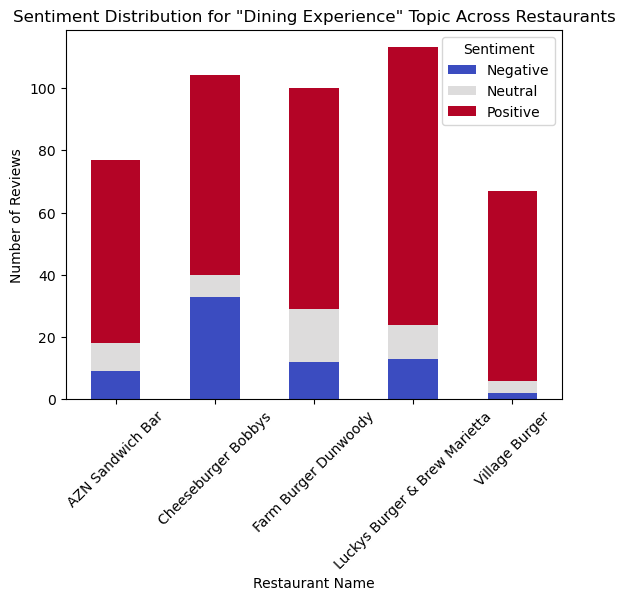

<Figure size 1000x600 with 0 Axes>

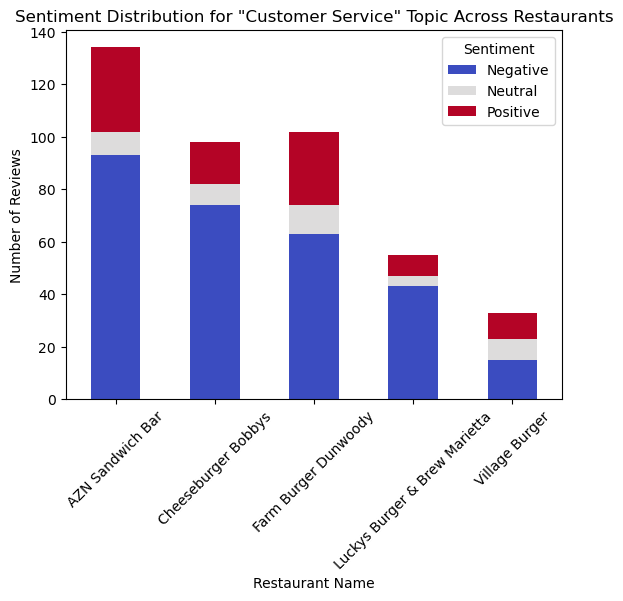

<Figure size 1000x600 with 0 Axes>

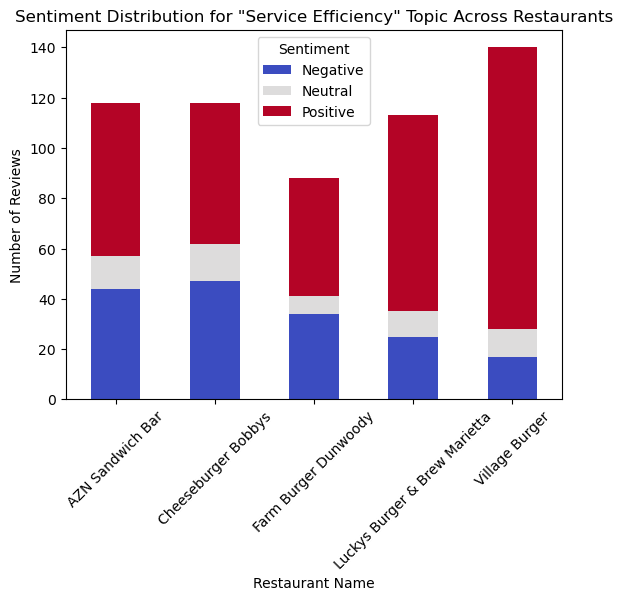

<Figure size 1000x600 with 0 Axes>

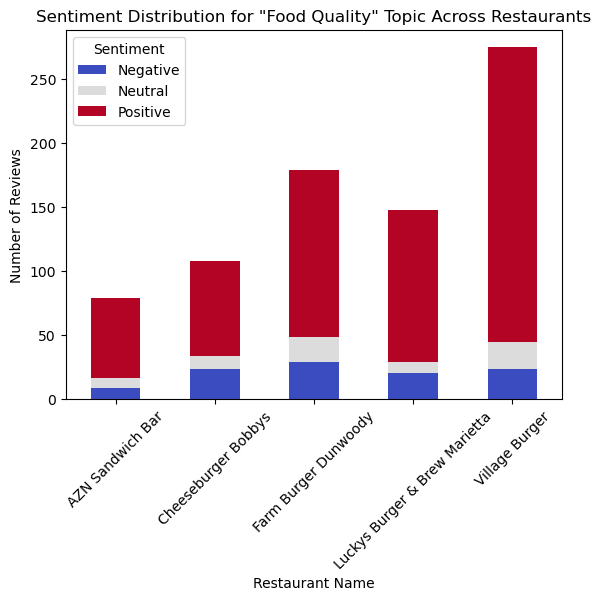

<Figure size 1000x600 with 0 Axes>

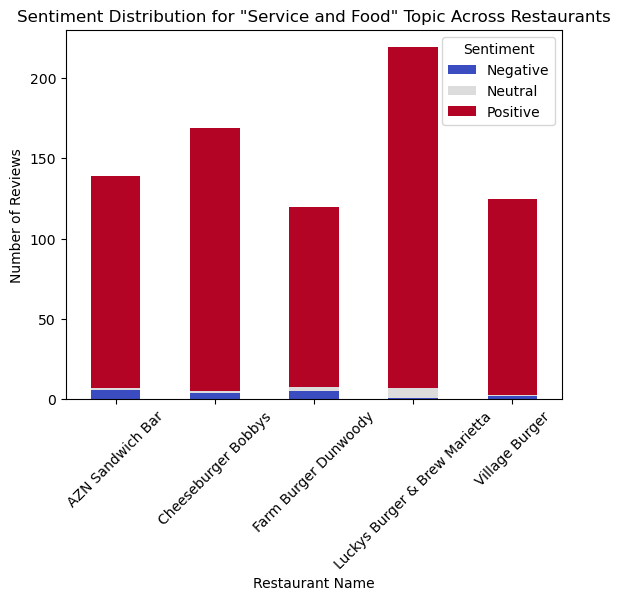

In [60]:
# Visualizing the sentiment distribution for each topic across restaurants
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting for each topic under LDA
for topic, label in lda_labels.items():
    plt.figure(figsize=(10, 6))
    
    # Filtering data for the current topic
    topic_data = df[df['LDA_Topic_Label'] == label]
    
    # Grouping by restaurant and sentiment to count the number of reviews
    sentiment_count = topic_data.groupby(['Restaurant Name', 'Sentiment']).size().unstack(fill_value=0)
    
    # Plotting the sentiment distribution for this topic
    sentiment_count.plot(kind='bar', stacked=True, colormap='coolwarm')
    plt.title(f'Sentiment Distribution for "{label}" Topic Across Restaurants')
    plt.xlabel('Restaurant Name')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45)
    plt.legend(title='Sentiment')
    plt.show()






<Figure size 1000x600 with 0 Axes>

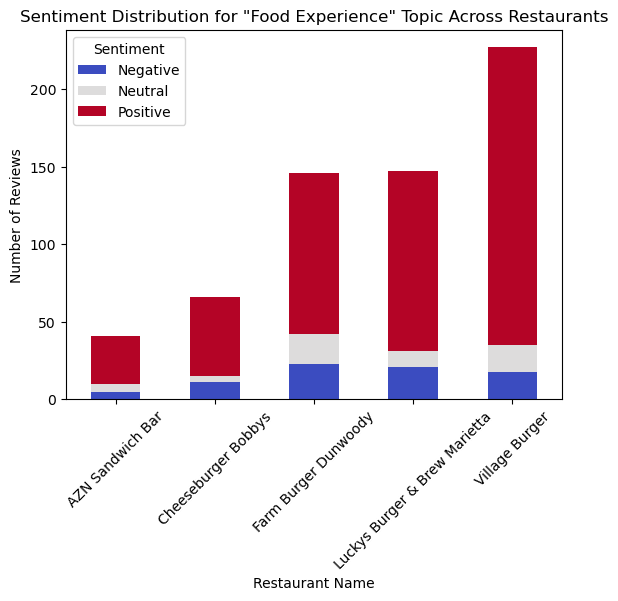

<Figure size 1000x600 with 0 Axes>

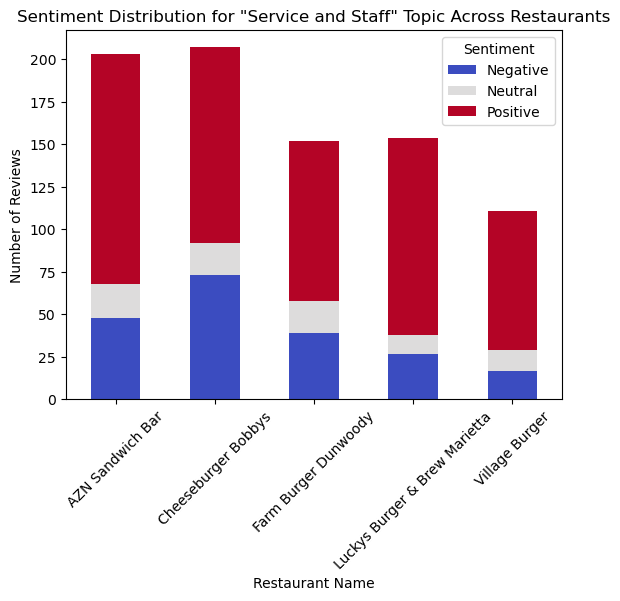

<Figure size 1000x600 with 0 Axes>

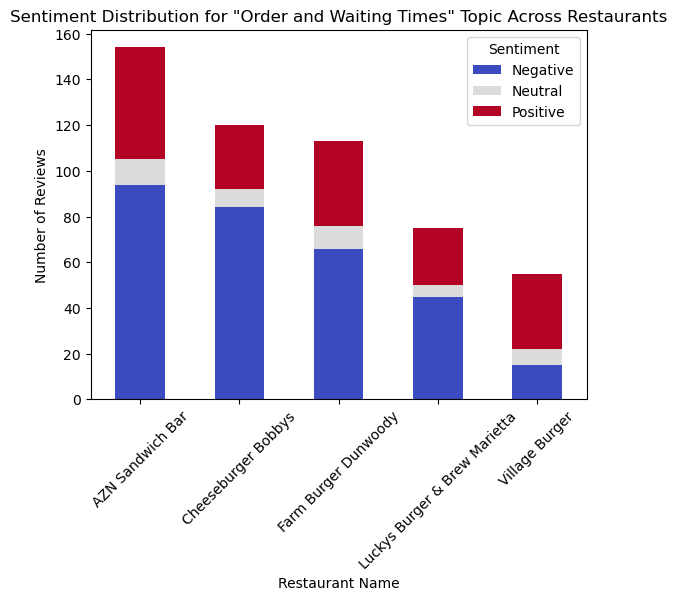

<Figure size 1000x600 with 0 Axes>

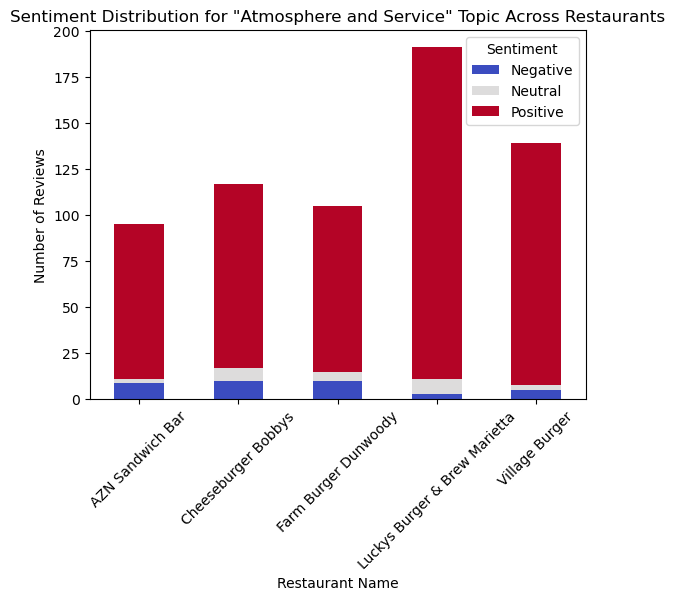

<Figure size 1000x600 with 0 Axes>

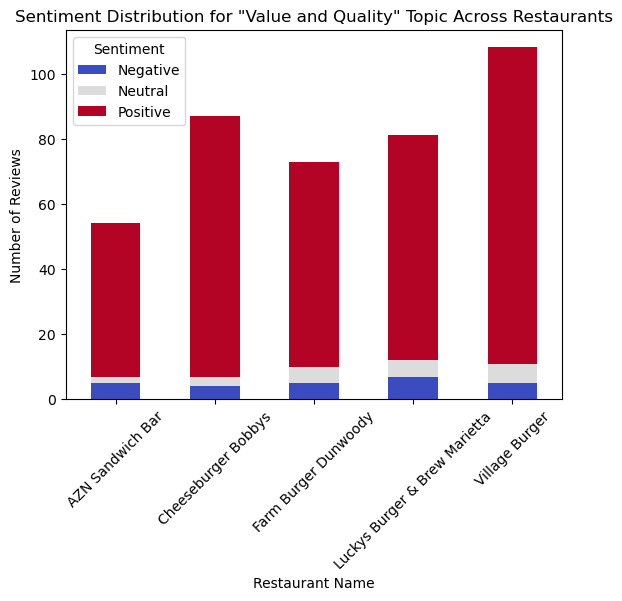

In [61]:
# Plotting for each topic under NMF
for topic, label in nmf_labels.items():
    plt.figure(figsize=(10, 6))
    
    # Filter data for the current topic
    topic_data = df[df['NMF_Topic_Label'] == label]
    
    # Grouping by restaurant and sentiment to count the number of reviews
    sentiment_count = topic_data.groupby(['Restaurant Name', 'Sentiment']).size().unstack(fill_value=0)
    
    # Plotting the sentiment distribution for this topic
    sentiment_count.plot(kind='bar', stacked=True, colormap='coolwarm')
    plt.title(f'Sentiment Distribution for "{label}" Topic Across Restaurants')
    plt.xlabel('Restaurant Name')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45)
    plt.legend(title='Sentiment')
    plt.show()

In [63]:
# Filterin the reviews for Village Burger and Cheeseburger Bobbys
village_burger_reviews = df[df['Restaurant Name'] == 'Village Burger']
cheeseburger_bobbys_reviews = df[df['Restaurant Name'] == 'Cheeseburger Bobbys']

# Grouping by 'LDA Topic Label' and 'Sentiment' to count the occurrences
village_burger_topic_sentiment = village_burger_reviews.groupby(['LDA_Topic_Label', 'Sentiment']).size().unstack(fill_value=0)
cheeseburger_bobbys_topic_sentiment = cheeseburger_bobbys_reviews.groupby(['LDA_Topic_Label', 'Sentiment']).size().unstack(fill_value=0)

# Finding the topic with the most positive reviews for Village Burger
most_positive_topic_village_burger = village_burger_topic_sentiment['Positive'].idxmax()

# Finding the topic with the most negative reviews for Cheeseburger Bobbys
most_negative_topic_cheeseburger_bobbys = cheeseburger_bobbys_topic_sentiment['Negative'].idxmax()

print(f"Topic with the most positive reviews for Village Burger: {most_positive_topic_village_burger}")
print(f"Topic with the most negative reviews for Cheeseburger Bobbys: {most_negative_topic_cheeseburger_bobbys}")


Topic with the most positive reviews for Village Burger: Food Quality
Topic with the most negative reviews for Cheeseburger Bobbys: Customer Service


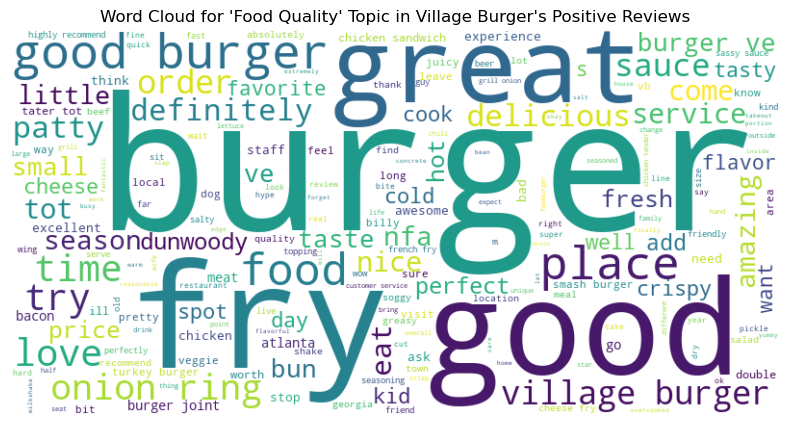

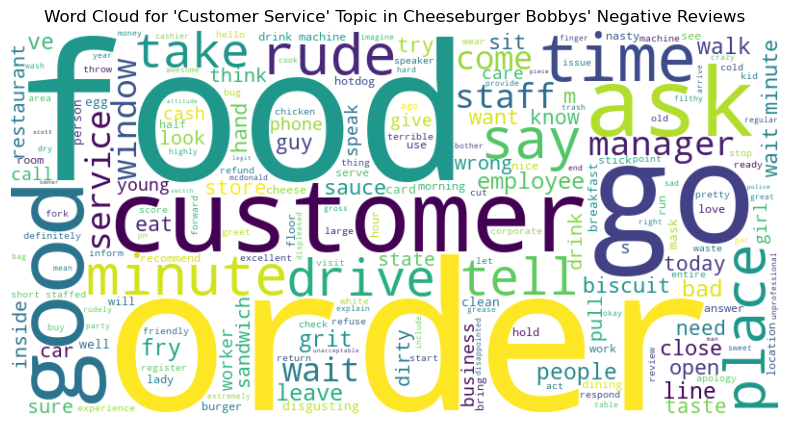

In [65]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate and display Word Cloud
def generate_wordcloud(data, title):
    text = ' '.join(data)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Filter the reviews under the most positive topic for Village Burger
village_burger_positive_reviews = village_burger_reviews[village_burger_reviews['LDA_Topic_Label'] == most_positive_topic_village_burger]

# Generate Word Cloud for Village Burger
generate_wordcloud(village_burger_positive_reviews['Processed Reviews'], f"Word Cloud for '{most_positive_topic_village_burger}' Topic in Village Burger's Positive Reviews")

# Filter the reviews under the most negative topic for Cheeseburger Bobbys
cheeseburger_bobbys_negative_reviews = cheeseburger_bobbys_reviews[cheeseburger_bobbys_reviews['LDA_Topic_Label'] == most_negative_topic_cheeseburger_bobbys]

# Generate Word Cloud for Cheeseburger Bobbys
generate_wordcloud(cheeseburger_bobbys_negative_reviews['Processed Reviews'], f"Word Cloud for '{most_negative_topic_cheeseburger_bobbys}' Topic in Cheeseburger Bobbys' Negative Reviews")
